## Data Understanding

Untuk memahami dataset berupa gambar, definisikan terlebih dahulu direktori datasetnya ke dalam sebuah variabel. Selanjutnya tiap kelas atau label yang tersedia dapat diketahui dengan memanggil os.listdir



In [8]:
import os
base_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'

In [9]:
print(os.listdir(base_dir))

['nv', 'mel', 'vasc', 'scc', 'sk', 'bcc', 'akice', 'df', 'pbk']


Untuk mengetahui jumlah file yang ada, dapat menggunakan fungsi len() pada tiap direktori label dan menjumlahkannya. Untuk memudahkan pembacaan data dapat juga divisualisasikan menggunakan bantuan library matplotlib.



In [10]:
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 2239


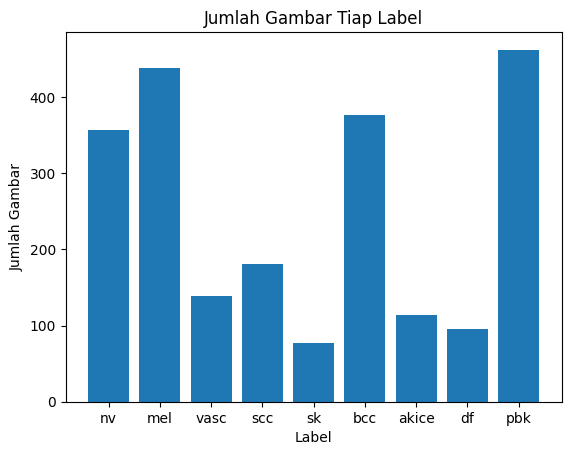

In [11]:
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

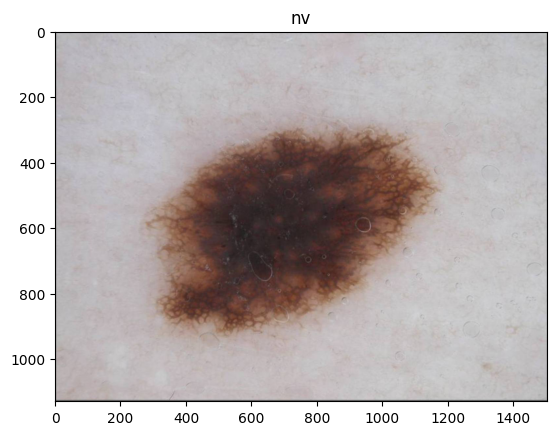

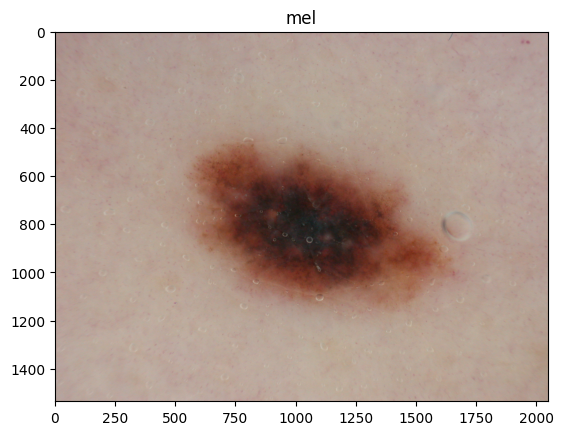

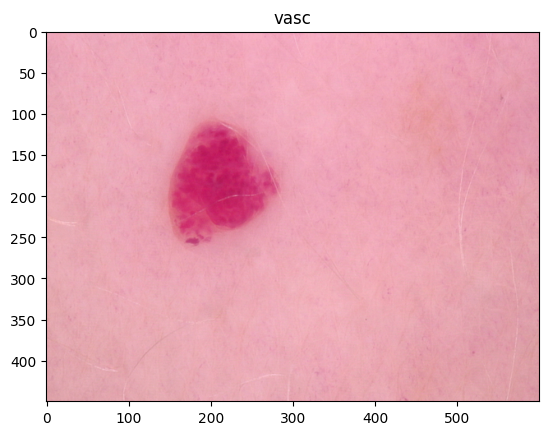

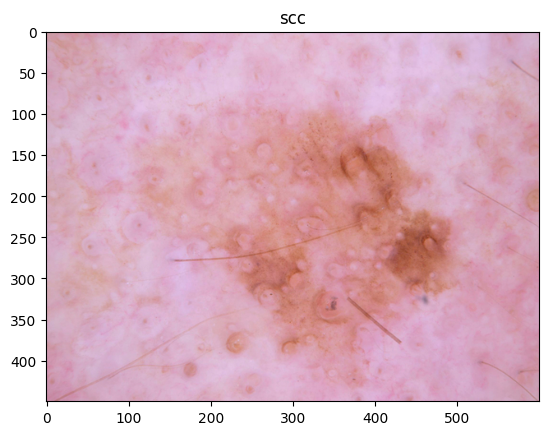

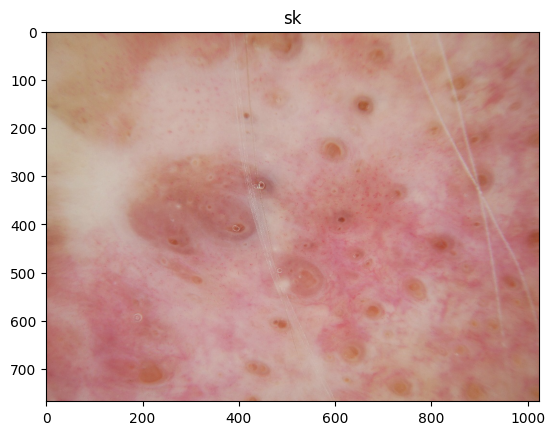

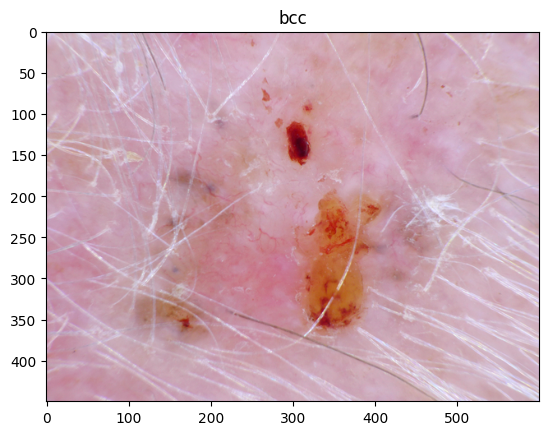

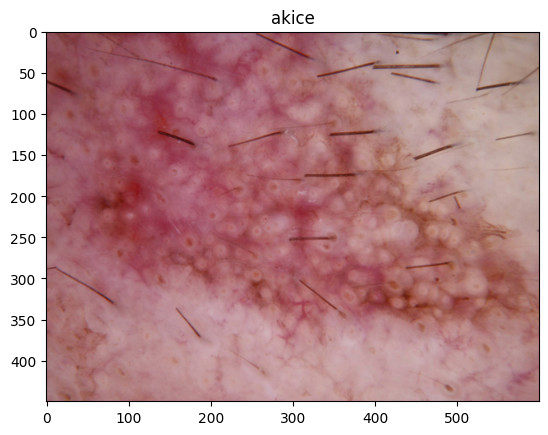

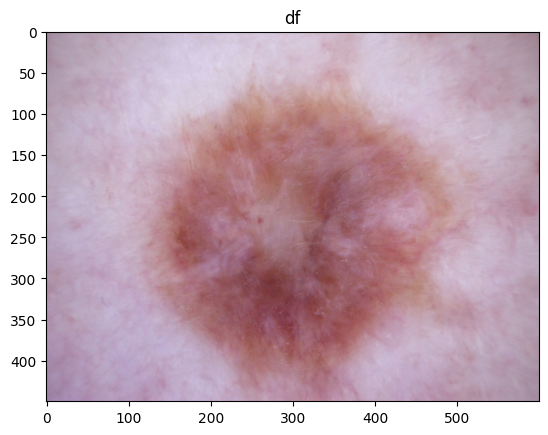

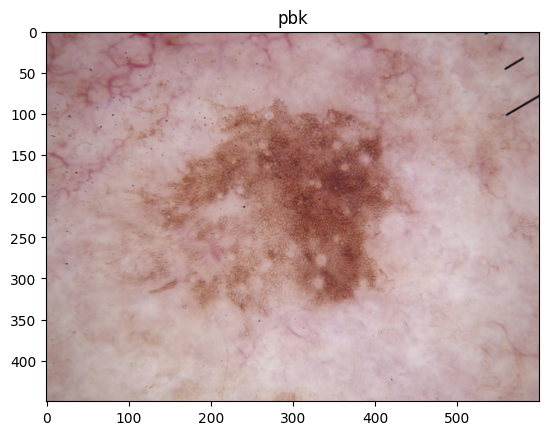

In [12]:
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

## Data Preparation

In [13]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [14]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [15]:
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [16]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

# Modelling

##Membuat Arsitektur CNN

Penyusunan Layer

In [17]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model CNN

In [18]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Epoch 1/5
57/57 [==============================] - 589s 10s/step - loss: 2.0026 - accuracy: 0.2574 - val_loss: 1.9098 - val_accuracy: 0.2838
Epoch 2/5
57/57 [==============================] - 230s 4s/step - loss: 1.6863 - accuracy: 0.4028 - val_loss: 1.6817 - val_accuracy: 0.3896
Epoch 3/5
57/57 [==============================] - 217s 4s/step - loss: 1.5140 - accuracy: 0.4680 - val_loss: 1.6687 - val_accuracy: 0.4347
Epoch 4/5
57/57 [==============================] - 242s 4s/step - loss: 1.4854 - accuracy: 0.5047 - val_loss: 1.6870 - val_accuracy: 0.4820
Epoch 5/5
57/57 [==============================] - 236s 4s/step - loss: 1.4495 - accuracy: 0.4891 - val_loss: 1.7103 - val_accuracy: 0.4324


Evaluasi Model CNN

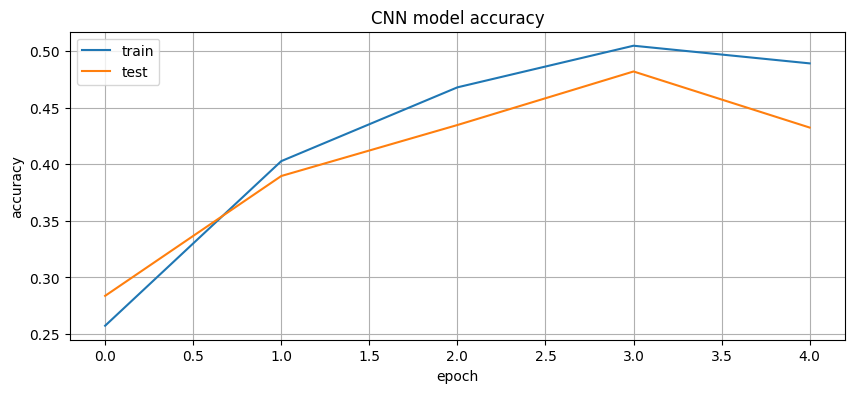

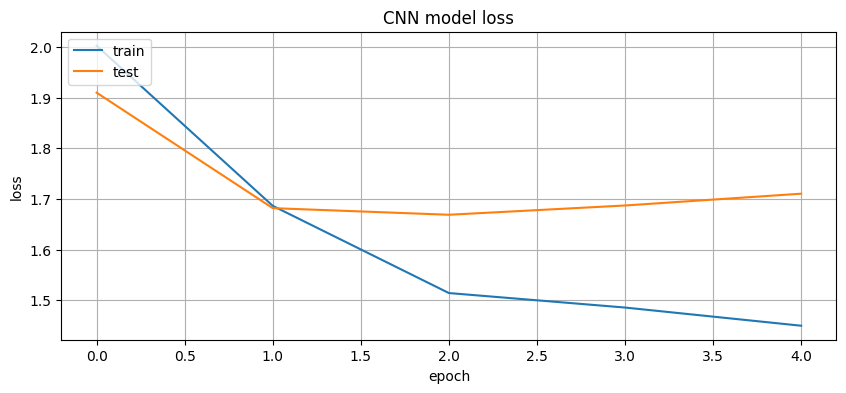

In [19]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Transfer Learning Menggunakan VGG16

Memuat Model VGG16

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [ ]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Epoch 1/5
57/57 [==============================] - ETA: 0s - loss: 2.0813 - accuracy: 0.2240 

Evaluasi Model

In [ ]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Transfer Learning Menggunakan ResNet50

Memuat Model ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(9, activation="softmax")
])

In [ ]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [ ]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Evaluasi Model

In [ ]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Transfer Learning Menggunakan DenseNet201

Memuat Model DenseNet201

In [ ]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

In [ ]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [ ]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Evaluasi Model

In [ ]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

#Evaluation

Setelah membuat beberapa model, maka dapat kita bandingkan akurasi dari model-model tersebut dengan visualisasi berikut ini.



In [ ]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

Dari hasil tersebut dapat diketahui bahwa model dengan DenseNet201 memiliki kinerja yang lebih baik. Untuk itu model tersebut yang akan dipilih untuk digunakan.

# Uji Coba Model

Setelah mendapatkan model dengan kinerja yang baik, maka dapat diujicobakan untuk mengenali gambar kanker .



In [ ]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

In [ ]:
# Menguji coba model
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('akice')
  elif classes==1:
    print('bcc')
  elif classes==2:
    print('df')
  elif classes==3:
    print('mel')
  elif classes==4:
    print('nv')
  elif classes==5:
    print('pbk')
  elif classes==6:
    print('scc')
  elif classes==7:
    print('sk')
  else:
    print('vasc')

# Deployment

Agar nantinya dapat diimplementasikan atau dikembangkan lebih lanjut, model perlu dilakukan deploy terlebih dahulu dalam format HDF5, TFLite (Mobile) atau TensorflowJS (Web)

HDF5

In [ ]:
densenet_model.save('model-flowers-recognition.h5')

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

TensorflowJS

In [ ]:
# Instal TensorflowJS
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.11
    Uninstalling flax-0.6.11:
      Successfully uninstalled flax-0.6.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xarray 2022.12.0 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs

2023-07-02 14:49:20.584702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Penutup

Saat ini model machine learning untuk mengenali gambar bunga telah didapatkan. Dengan model ini dapat diimplementasikan lebih lanjut menjadi aplikasi web atau mobile untuk mengenali jenis bunga. Namun tentu saja model ini juga masih dapat disempurnakan dengan mencoba pretrained model yang lain, melakukan fine-tuning, atau dengan mengubah dataset yang lebih beragam dan berkualitas.